In [1]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(1)

In [2]:
keywords = pd.read_csv('keywords_preprocessed.csv')
meta = pd.read_csv('movies_metadata_preprocessed.csv')
ratings = pd.read_csv('ratings_preprocessed.csv')

In [4]:
#random_state in the train test split has been set to 1 to recreate results, remove it to review model
df_numeric = meta[['budget','popularity','revenue','runtime','vote_average','vote_count']]
df_numeric.dropna(inplace=True)
#new feature "new" has been engineered to be able to use the votes provided by viewers while trying to 
#give importance to number of voters
factors = [i for i in np.arange(0.1,1.0,0.1)]
for factor in factors:
    df_numeric['new'+str(factor)[:3]] = df_numeric['vote_average']*np.power(df_numeric['vote_count'],factor)
train,test = train_test_split(df_numeric,test_size=0.25,random_state = 1)

/Users/rahulshiv/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rahulshiv/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
x = train.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = df_numeric.columns

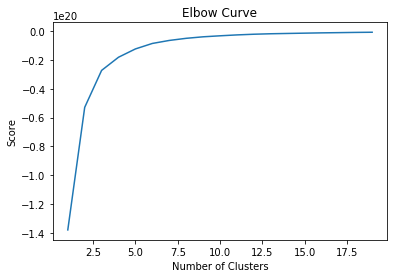

In [6]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
y = np.array(train.revenue).reshape(-1,1)
score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [7]:
#we look at the graph and not that elbow is at 4 and hence we choose 4 as cluster number
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit(y).predict(y)
train['cluster'] = kmeans.labels_


/Users/rahulshiv/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [8]:
print('Size of clusters : ',[len(train[train.cluster==i]) for i in range(4)])

Size of clusters :  [31386, 299, 76, 1239]


In [9]:
train.groupby(['cluster']).mean()

,budget,popularity,revenue,runtime,vote_average,vote_count,new0.1,new0.2,new0.3,new0.4,new0.5,new0.6,new0.7,new0.8,new0.9
cluster,,,,,,,,,,,,,,,
0,5.434366e+06,2.463222,9.072327e+06,93.623017,5.605451,46.645033,7.326949,9.833964,13.576316,19.306858,28.311501,42.830378,66.840877,107.534800,178.144258
1,9.170086e+07,16.558677,3.786897e+08,117.515050,6.589967,2498.745819,14.153188,30.562154,66.333839,144.674180,316.993530,697.627692,1541.808000,3421.339573,7621.711925
2,1.611053e+08,50.213540,9.394031e+08,132.342105,6.976316,5564.539474,16.425856,38.750059,91.591150,216.902612,514.634187,1223.338590,2913.397539,6951.011006,16614.253352
3,4.342670e+07,10.927328,1.239271e+08,120.004843,6.324213,879.916868,11.840620,22.553794,43.585216,85.278127,168.674496,336.881007,678.798844,1378.956844,2822.756607


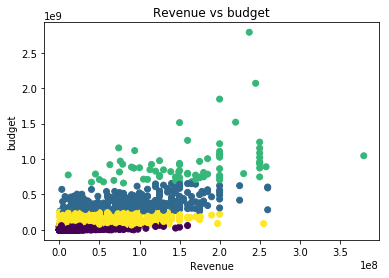

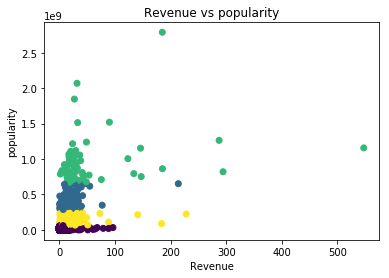

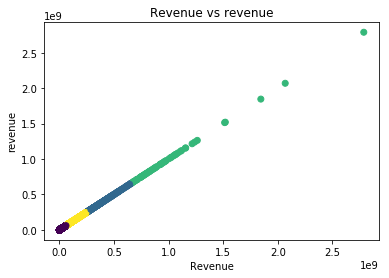

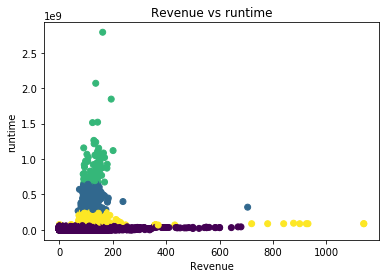

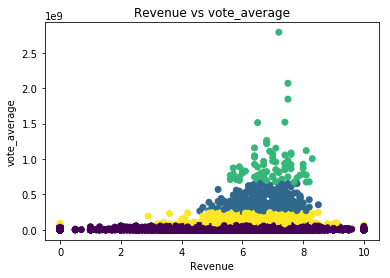

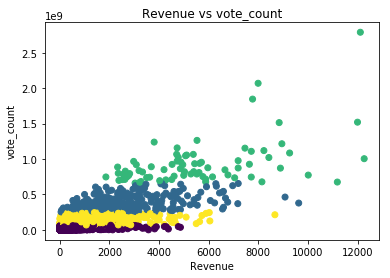

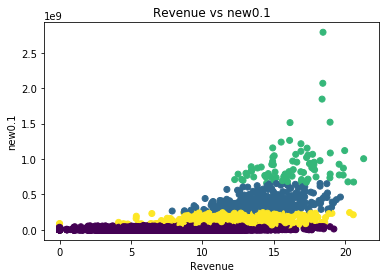

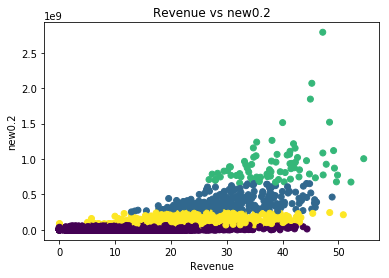

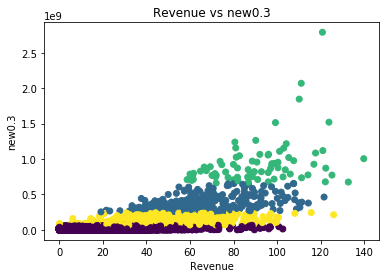

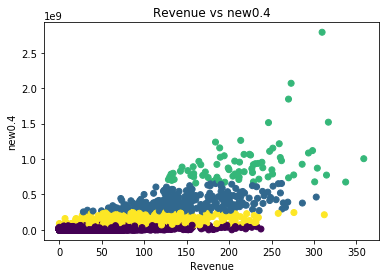

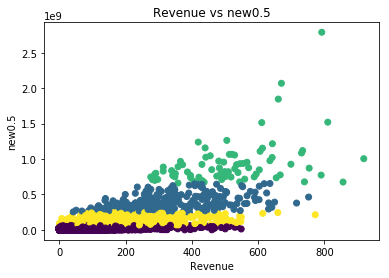

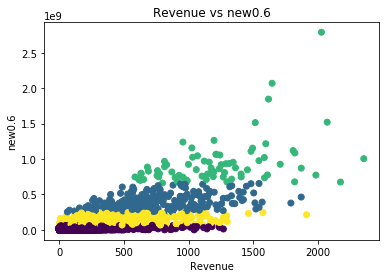

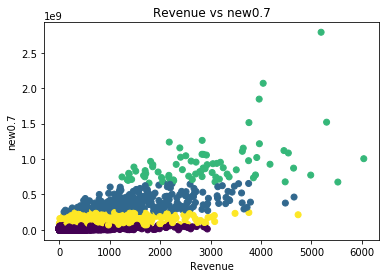

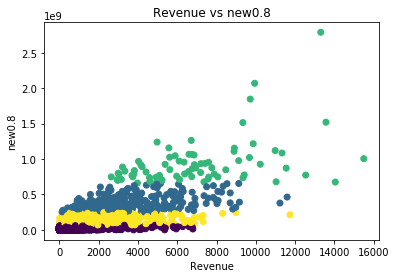

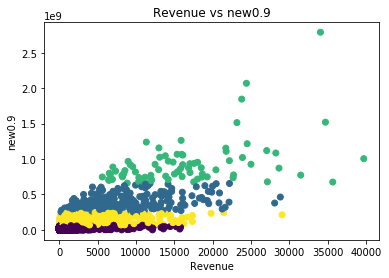

In [10]:
size_array = list(train.groupby(['cluster']).count()['revenue'].values)
train[train['cluster']==size_array.index(sorted(size_array)[0])].revenue.mean()
for i in train.iloc[:,:-1]:
    plt.scatter(train[i],train['revenue'],c=kmeans.labels_)
    plt.xlabel("Revenue")
    plt.ylabel(i)
    plt.title('Revenue vs '+i)
    plt.show()

In [11]:
cluster1 = train[train.cluster==0]
cluster1 = cluster1[cluster1.revenue!=0]
print('Size of cluster 1: ',len(cluster1))

Size of cluster 1:  31386


In [12]:
#we can observe clusters in the train and test dataset
test_clusters = kmeans.predict(test.revenue.values.reshape(-1,1))
test['cluster'] = test_clusters
print(train.groupby(['cluster']).mean())
print(test.groupby(['cluster']).mean())

               budget  popularity       revenue     runtime  vote_average  \
cluster                                                                     
0        5.434366e+06    2.463222  9.072327e+06   93.623017      5.605451   
1        9.170086e+07   16.558677  3.786897e+08  117.515050      6.589967   
2        1.611053e+08   50.213540  9.394031e+08  132.342105      6.976316   
3        4.342670e+07   10.927328  1.239271e+08  120.004843      6.324213   

          vote_count     new0.1     new0.2     new0.3      new0.4      new0.5  \
cluster                                                                         
0          46.645033   7.326949   9.833964  13.576316   19.306858   28.311501   
1        2498.745819  14.153188  30.562154  66.333839  144.674180  316.993530   
2        5564.539474  16.425856  38.750059  91.591150  216.902612  514.634187   
3         879.916868  11.840620  22.553794  43.585216   85.278127  168.674496   

              new0.6       new0.7       new0.8    

/Users/rahulshiv/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
from datetime import datetime
meaan = []
meta.loc[:,'release_date']=pd.to_datetime(meta.release_date, format = '%Y-%m-%d', errors="coerce")
for i in range(1970,2018,5):
    mask = (meta['release_date'] >= str(i)+'-1-1') & (meta['release_date'] < str(i+5)+'-1-1')
    tdf = meta[mask]
    tdf = tdf.sort_values(['release_date'])
    dates = np.array([j for j in tdf.release_date])
    print(str(i)+" To "+str(i+5))
    print("Mean budget "+str(tdf.budget.mean()))
    meaan.append(tdf.budget.mean())
#Indicates an increase in budget over the years. Here every 5 years from 1970 onwards is taken. This is to show that the 
#inflation of the prices over the years need not be separately accounted using any factor as the budget itself is increasing
#across the years
rates = [meaan[i+1]/meaan[i] for i in range(len(meaan)-1)]
rates.insert(0,1)
rates = [i**-1 for i in rates]
# print(rates)

1970 To 1975
Mean budget 3790018.0715419464
1975 To 1980
Mean budget 4934647.903049159
1980 To 1985
Mean budget 6160134.361463692
1985 To 1990
Mean budget 7003717.319942057
1990 To 1995
Mean budget 8767766.285978835
1995 To 2000
Mean budget 10801092.756497527
2000 To 2005
Mean budget 11292155.545526931
2005 To 2010
Mean budget 10043233.545322001
2010 To 2015
Mean budget 9318655.759730736
2015 To 2020
Mean budget 10074713.755130522


In [15]:
#Linear regression done on selected attributes
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
factors_dict = dict()
for factor in factors:
    X = train[['budget','popularity','new'+str(factor)[:3]]]
    release = meta[['release_date']]
    y = train[['revenue']]

    lm = linear_model.LinearRegression(fit_intercept=False)
    model = lm.fit(X,y)
    predictions = lm.predict(X)
    pred = pd.DataFrame(predictions,columns=["revenue"])
    y['revenue_pred'] = predictions

    for i in X.index:
        ind = (meta.iloc[i].release_date.year - 1970)//5
        y.loc[i].revenue_pred = y.loc[i].revenue_pred*rates[ind]

    y['log_actuals'] = np.log10(y.revenue)
    y['log_pred'] = np.log10(y.revenue_pred)
    factors_dict[str(factor)[:3]] = model.score(X,y.revenue)

#RMSE is as follows
print("RMSE = "+str((mean_squared_error(y.revenue,y.revenue_pred))**0.5))
print("LOG RMSE = "+str((mean_squared_error(y.log_actuals,y.log_pred))**0.5))
#R Sqaured is as follows
residuals = y.revenue - y.revenue_pred
plt.scatter(y.revenue,y.revenue_pred,c=kmeans.labels_)
plt.xlabel("Actuals Revenue")
plt.ylabel("Predicted Revenue")
plt.show()
plt.scatter(y.revenue_pred,residuals,c=kmeans.labels_)
plt.xlabel("Residuals")
plt.ylabel("Predicted")
plt.show()

for key, value in factors_dict.items():
    print(key,' : ',value)

/Users/rahulshiv/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:539: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
/Users/rahulshiv/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


IndexError: list index out of range